# Lab 6: Transformers

In this lab, we will apply the transformer architecture from the tutorial to various tasks:
* Sequence-to-Sequence modelling
* Set anomaly detection. 


### Question 1: Sequence to Sequence

A Sequence-to-Sequence task represents a task where the input _and_ the output is a sequence, e.g. as in machine translation and summarization. Usually we would use an encoder-decoder architecture for this, but for now we'll use only the encoder om a simple task: given a sequence of $N$ numbers between $0$ and $M$, the task is to reverse the input sequence. In Numpy notation, if our input is $x$, the output should be $x$[::-1]. 

##### The data
First, let's create a dataset class below.

In [14]:
class ReverseDataset(data.Dataset):

    def __init__(self, num_categories, seq_len, size):
        super().__init__()
        self.num_categories = num_categories
        self.seq_len = seq_len
        self.size = size
        
        self.data = torch.randint(self.num_categories, size=(self.size, self.seq_len))
  
    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        inp_data = self.data[idx]
        labels = torch.flip(inp_data, dims=(0,))
        return inp_data, labels

We create an arbitrary number of random sequences of numbers between 0 and `num_categories-1`. The label is simply the tensor flipped over the sequence dimension. We can create the corresponding data loaders below. 

In [15]:
dataset = partial(ReverseDataset, 10, 16)
train_loader = data.DataLoader(dataset(50000), batch_size=128, shuffle=True, drop_last=True, pin_memory=True)
val_loader   = data.DataLoader(dataset(1000), batch_size=128)
test_loader  = data.DataLoader(dataset(10000), batch_size=128)

Let's look at an arbitrary sample of the dataset:

In [16]:
inp_data, labels = train_loader.dataset[0]
print("Input data:", inp_data)
print("Labels:    ", labels)

Input data: tensor([9, 6, 2, 0, 6, 2, 7, 9, 7, 3, 3, 4, 3, 7, 0, 9])
Labels:     tensor([9, 0, 7, 3, 4, 3, 3, 7, 9, 7, 2, 6, 0, 2, 6, 9])


##### The model
Create a class `ReversePredictor`, which extends the `TransformerPredictor` we created in the tutorial. During training, pass the input sequence through the Transformer encoder and predict the output for each input token. You can use standard Cross-Entropy loss. Every number can be represented as a one-hot vector, or a learned embedding vector provided by the PyTorch module `nn.Embedding`. 

Create a training function for PyTorch Lightning, and also test your model on the test set. Experiment with adding an additional parameter `gradient_clip_val` that implements [gradient clipping](https://deepai.org/machine-learning-glossary-and-terms/gradient-clipping)).

##### The trainer 
Train the model, use a single encoder block and a single head in the Multi-Head Attention. This should be ok for this simple task.

##### Visualization
Try to visualize the attention in the Multi-Head Attention block, for an arbitrary input. Next, create a plot where over rows, we have different layers, while over columns, we show the different heads, i.e. a matrix visualizing all the attention values.

### Set Anomaly Detection 

Transformers offer the perfect architecture for set problems as the Multi-Head Attention is permutation-equivariant, and thus, outputs the same values no matter in what order we enter the inputs (inputs and outputs are permuted equally). The task we are looking at for sets is _Set Anomaly Detection_ which means that we try to find the element(s) in a set that does not fit the others. A common application of anomaly detection is performed on a set of images, where $N-1$ images belong to the same category/have the same high-level features while one belongs to another category. Note that category does not necessarily have to relate to a class in a standard classification problem, but could be the combination of multiple features. For instance, on a face dataset, this could be people with glasses, male, beard, etc. An example of distinguishing different animals can be seen below. The first four images show foxes, while the last represents a different animal. We want to recognize that the last image shows a different animal, but it is not relevant which class of animal it is.

<center width="100%" style="padding:20px"><img src="../notebooks/images/cifar100_example_anomaly.png" width="600px"></center>

##### The data
We will use the CIFAR100 dataset. CIFAR100 has 600 images for 100 classes each with a resolution of 32x32, similar to CIFAR10. The larger amount of classes requires the model to attend to specific features in the images instead of coarse features as in CIFAR10, therefore making the task harder. We will show the model a set of 9 images of one class, and 1 image from another class. The task is to find the image that is from a different class than the other images.

Using the raw images directly as input to the Transformer is not a good idea, because it is not translation invariant as a CNN. Use a pre-trained ResNet34 model from the torchvision package to obtain high-level, low-dimensional features of the images. Below, we will load the dataset.

In [ ]:
# ImageNet statistics
DATA_MEANS = np.array([0.485, 0.456, 0.406])
DATA_STD = np.array([0.229, 0.224, 0.225])
# As torch tensors for later preprocessing
TORCH_DATA_MEANS = torch.from_numpy(DATA_MEANS).view(1,3,1,1)
TORCH_DATA_STD = torch.from_numpy(DATA_STD).view(1,3,1,1)

# Resize to 224x224, and normalize to ImageNet statistic
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(DATA_MEANS, DATA_STD)
                                ])
# Loading the training dataset. 
train_set = CIFAR100(root=DATASET_PATH, train=True, transform=transform, download=True)

# Loading the test set
test_set = CIFAR100(root=DATASET_PATH, train=False, transform=transform, download=True)

100%|██████████| 169M/169M [00:07<00:00, 22.1MB/s] 


Next, run a pre-trained ResNet model on the images, and extract the features before the classification layer. These are the most high-level features, and should sufficiently describe the images. As we don't have a large enough dataset and want to train our model efficiently, it's best to extract the features beforehand.

This is a validation set to detect when we should stop training. In this case, we will split the training set into 90% training, 10% validation in a balanced way.

In [ ]:
## Split train into train+val
# Get labels from train set
labels = train_set.targets

# Get indices of images per class
labels = torch.LongTensor(labels)
num_labels = labels.max()+1
sorted_indices = torch.argsort(labels).reshape(num_labels, -1) # [classes, num_imgs per class]

# Determine number of validation images per class
num_val_exmps = sorted_indices.shape[1] // 10

# Get image indices for validation and training
val_indices   = sorted_indices[:,:num_val_exmps].reshape(-1)
train_indices = sorted_indices[:,num_val_exmps:].reshape(-1)

# Group corresponding image features and labels
train_feats, train_labels = train_set_feats[train_indices], labels[train_indices]
val_feats,   val_labels   = train_set_feats[val_indices],   labels[val_indices]

We create a dataset class for the set anomaly task. We define an epoch to be the sequence in which each image has been exactly once as an "anomaly". Hence, the length of the dataset is the number of images in it. For the training set, each time we access an item with `__getitem__`, we sample a random, different class than the image at the corresponding index `idx` has. In a second step, we sample $N-1$ images of this sampled class. The set of 10 images is finally returned. The randomness in the `__getitem__` allows us to see a slightly different set during each iteration. However, we can't use the same strategy for the test set as we want the test dataset to be the same every time we iterate over it. Hence, we sample the sets in the `__init__` method, and return those in `__getitem__`. The code below implements exactly this dynamic.

In [ ]:
class SetAnomalyDataset(data.Dataset):
    
    def __init__(self, img_feats, labels, set_size=10, train=True):
        """
        Inputs:
            img_feats - Tensor of shape [num_imgs, img_dim]. Represents the high-level features.
            labels - Tensor of shape [num_imgs], containing the class labels for the images
            set_size - Number of elements in a set. N-1 are sampled from one class, and one from another one.
            train - If True, a new set will be sampled every time __getitem__ is called.
        """
        super().__init__()
        self.img_feats = img_feats
        self.labels = labels
        self.set_size = set_size-1 # The set size is here the size of correct images
        self.train = train
        
        # Tensors with indices of the images per class
        self.num_labels = labels.max()+1
        self.img_idx_by_label = torch.argsort(self.labels).reshape(self.num_labels, -1)
        
        if not train:
            self.test_sets = self._create_test_sets()
            
            
    def _create_test_sets(self):
        # Pre-generates the sets for each image for the test set
        test_sets = []
        num_imgs = self.img_feats.shape[0]
        np.random.seed(42)
        test_sets = [self.sample_img_set(self.labels[idx]) for idx in range(num_imgs)]
        test_sets = torch.stack(test_sets, dim=0)
        return test_sets
            
        
    def sample_img_set(self, anomaly_label):
        """
        Samples a new set of images, given the label of the anomaly. 
        The sampled images come from a different class than anomaly_label
        """
        # Sample class from 0,...,num_classes-1 while skipping anomaly_label as class
        set_label = np.random.randint(self.num_labels-1)
        if set_label >= anomaly_label:
            set_label += 1
            
        # Sample images from the class determined above
        img_indices = np.random.choice(self.img_idx_by_label.shape[1], size=self.set_size, replace=False)
        img_indices = self.img_idx_by_label[set_label, img_indices]
        return img_indices
        
        
    def __len__(self):
        return self.img_feats.shape[0]
    
    
    def __getitem__(self, idx):
        anomaly = self.img_feats[idx]
        if self.train: # If train => sample
            img_indices = self.sample_img_set(self.labels[idx])
        else: # If test => use pre-generated ones
            img_indices = self.test_sets[idx]
            
        # Concatenate images. The anomaly is always the last image for simplicity
        img_set = torch.cat([self.img_feats[img_indices], anomaly[None]], dim=0)
        indices = torch.cat([img_indices, torch.LongTensor([idx])], dim=0)
        label = img_set.shape[0]-1
        
        # We return the indices of the images for visualization purpose. "Label" is the index of the anomaly
        return img_set, indices, label

Next, we can setup our datasets and data loaders below. Here, we will use a set size of 10, i.e. 9 images from one category + 1 anomaly. Feel free to change it if you want to experiment with the sizes. 

In [ ]:
SET_SIZE = 10
test_labels = torch.LongTensor(test_set.targets)

train_anom_dataset = SetAnomalyDataset(train_feats, train_labels, set_size=SET_SIZE, train=True)
val_anom_dataset   = SetAnomalyDataset(val_feats,   val_labels,   set_size=SET_SIZE, train=False)
test_anom_dataset  = SetAnomalyDataset(test_feats,  test_labels,  set_size=SET_SIZE, train=False)

train_anom_loader = data.DataLoader(train_anom_dataset, batch_size=64, shuffle=True,  drop_last=True,  num_workers=0, pin_memory=True)
val_anom_loader   = data.DataLoader(val_anom_dataset,   batch_size=64, shuffle=False, drop_last=False, num_workers=0)
test_anom_loader  = data.DataLoader(test_anom_dataset,  batch_size=64, shuffle=False, drop_last=False, num_workers=0)

To understand the dataset a little better, we can plot below a few sets from the test dataset. Each row shows a different input set, where the first 9 are from the same class.

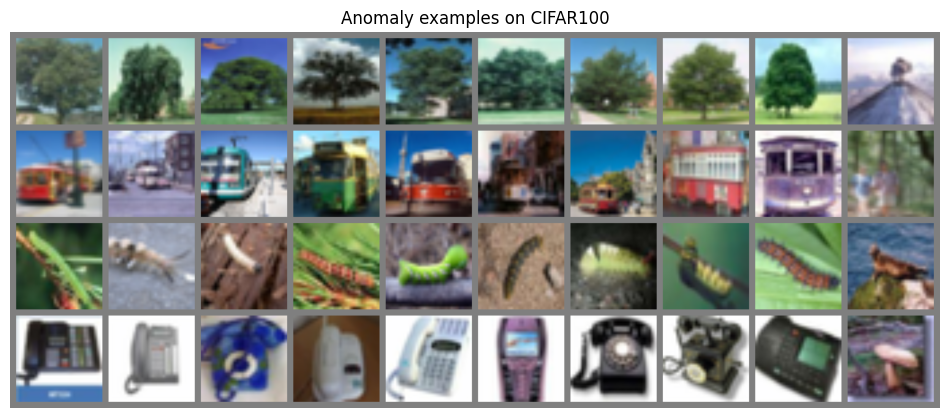

In [ ]:
def visualize_exmp(indices, orig_dataset):
    images = [orig_dataset[idx][0] for idx in indices.reshape(-1)]
    images = torch.stack(images, dim=0)
    images = images * TORCH_DATA_STD + TORCH_DATA_MEANS
    
    img_grid = torchvision.utils.make_grid(images, nrow=SET_SIZE, normalize=True, pad_value=0.5, padding=16)
    img_grid = img_grid.permute(1, 2, 0)

    plt.figure(figsize=(12,8))
    plt.title("Anomaly examples on CIFAR100")
    plt.imshow(img_grid)
    plt.axis('off')
    plt.show()
    plt.close()

_, indices, _ = next(iter(test_anom_loader))
visualize_exmp(indices[:4], test_set)

We can already see that for some sets the task might be easier than for others. Difficulties can especially arise if the anomaly is in a different, but yet visually similar class (e.g. train vs bus, flour vs worm, etc.).

##### The model
Write a model to classify whole set. For the prediction to be permutation-equivariant, output one logit for each image. Over these logits, apply a softmax and train the anomaly image to have the highest score/probability.

##### The trainer
Finally, write your train function below. It can have the exact same structure as the reverse task one. Train your model.

##### Visualization
To interpret the model a little more, we plot the attention maps inside the model. This should give you an idea of what information the model is sharing/communicating between images, and what each head might represent. Write a plot function which plots the images in the input set, the prediction of the model, and the attention maps of the different heads on layers of the transformer. Feel free to explore the attention maps for different input examples as well.